# 0. Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plot

from matplotlib.colors import ListedColormap

from scipy.spatial.distance import cosine

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.manifold import MDS
import umap

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap


from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact
from itertools import product
from sklearn.manifold import TSNE
from scipy import stats


from sklearn.cluster import KMeans
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


#

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1. Load data with vectors -> df_ini

In [3]:
def f_load(path,file_name):
    # Read data
    df_ini= pd.read_pickle(path+file_name)
    return df_ini

# 2.Test UMAP

### Test using Multiple Imputation by Chained Equations

In [4]:
def f_impute_MICE(data):
    # Impute NaN values using MICE (IterativeImputer)
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_data = imputer.fit_transform(data)
    return imputed_data

In [5]:
def f_impute_data(data):
    # Impute by sampling from the existing distribution -> by column
    data=data.astype(float)
    for i in range(data.shape[1]):
        column = data[:, i]
        non_nan_values = column[~np.isnan(column)]
        if len(non_nan_values) > 0:
            # Replace NaNs with a randomly chosen value from non-NaN values
            data[np.isnan(column), i] = np.random.choice(non_nan_values, size=np.isnan(column).sum())
    return data

In [6]:
def f_umap(data):   
    # Impute data
    imputed_data=f_impute_data(data)
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
    r_umap = reducer.fit_transform(imputed_data)
    return r_umap,imputed_data

# 3. Build distance matrix

## Small pause to test different distances/similarities

In [7]:
A1=np.array([1,0,1,0,0,0,0,1,1,0,0,1,0])
A2=np.array([1,1,1,0,0,1,0,1,1,0,0,1,0])
B=np.array([1,0,1,0,0,0,0,1,1,0,0,1,0])
C=np.array([0,0,0,0,1,0,1,0,0,0,0,1,0])
D=np.array([0,1,0,1,0,0,1,0,0,1,0,0,1])
E=np.array([0,0,0,0,0,0,1,0,0,0,0,0,0])
F=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

In [8]:
# Manhattan Distance
def f_manhattan(A,B):
    a=np.sum(A)
    b=np.sum(B)
    c=np.sum(A & B)
    return a+b-2*c

In [9]:
def f_jaccard(m_v1,m_v2,len_m):
    intersection = np.sum(m_v1 == m_v2)
    jaccard_distance = intersection / len_m
    return jaccard_distance

In [10]:
def f_hamming(m_v1,m_v2):
    return np.sum(m_v1 != m_v2)

In [11]:
# Cosine Similarity
def f_cosine_s(A,B):
    a=np.sum(A)
    b=np.sum(B)
    c=np.sum(A & B)
    return c/(a*b)**(1/2)

In [12]:
# Dice Similarity
def f_dice_s(A,B):
    a=np.sum(A)
    b=np.sum(B)
    c=np.sum(A & B)
    return (2*c)/(a+b)

In [13]:
VA=A1
len_m=len(A1)
test_v=[A1,A2,B,C,D,E,F]
res=[]
for i in range (len(test_v)):
    VB=test_v[i]
    fm=f_manhattan(VA,VB)
    fh=f_hamming(VA,VB)
    fj=f_jaccard(VA,VB,len_m)
    fc=f_cosine_s(VA,VB)
    fd=f_dice_s(VA,VB)
    res.append([fm,fh,fj,fc,fd])
res

[[0, 0, 1.0, 1.0, 1.0],
 [2, 2, 0.8461538461538461, 0.8451542547285166, 0.8333333333333334],
 [0, 0, 1.0, 1.0, 1.0],
 [6, 6, 0.5384615384615384, 0.2581988897471611, 0.25],
 [10, 10, 0.23076923076923078, 0.0, 0.0],
 [6, 6, 0.5384615384615384, 0.0, 0.0],
 [5, 5, 0.6153846153846154, nan, 0.0]]

In [14]:
VA=A2
res=[]
for i in range (len(test_v)):
    VB=test_v[i]
    fm=f_manhattan(VA,VB)
    fh=f_hamming(VA,VB)
    fj=f_jaccard(VA,VB,len_m)
    fc=f_cosine_s(VA,VB)
    fd=f_dice_s(VA,VB)
    res.append([fm,fh,fj,fc,fd])
res

[[2, 2, 0.8461538461538461, 0.8451542547285166, 0.8333333333333334],
 [0, 0, 1.0, 1.0, 1.0],
 [2, 2, 0.8461538461538461, 0.8451542547285166, 0.8333333333333334],
 [8, 8, 0.38461538461538464, 0.2182178902359924, 0.2],
 [10, 10, 0.23076923076923078, 0.1690308509457033, 0.16666666666666666],
 [8, 8, 0.38461538461538464, 0.0, 0.0],
 [7, 7, 0.46153846153846156, nan, 0.0]]

Comment:
1. Manhattan and Hamming allows us to measure the distance, we got the same result with both
2. Jaccard offers more detail about the similarity through the tested measurements

## Implementation

In [15]:
def f_distances(data):
    ldata=len(data)
    m_distance_j=np.zeros([ldata,ldata])
    m_distance_h=np.zeros([ldata,ldata])
    m_feat=np.zeros([ldata,ldata])
    
    for ivec in range(ldata):
        vector1=data[ivec].astype(float)
        
        for jvec in range(ivec+1,ldata):
            vector2=data[jvec].astype(float)
            mask = ~np.isnan(vector1) & ~np.isnan(vector2)
            m_v1 = vector1[mask].astype(bool)
            m_v2 = vector2[mask].astype(bool)
            len_m=len(m_v1)
            m_feat[ivec][jvec]=len_m
            
            if len_m>0:
                m_distance_j[ivec][jvec]= f_jaccard(m_v1,m_v2,len_m)
                m_distance_h[ivec][jvec]= f_hamming(m_v1,m_v2)
            else:
                m_distance_j[ivec][jvec]= np.nan
                m_distance_h[ivec][jvec]= np.nan
    
    m_distance_h=m_distance_h#/np.max(m_distance_h[m_distance_h>0])
    m_distance_j=m_distance_j + m_distance_j.T
    m_distance_h=m_distance_h + m_distance_h.T
    m_feat=m_feat+m_feat.T 
    return m_distance_j, m_distance_h, m_feat 

## 3.1 Distance Visualization

In [16]:
def f_data(df_vector, filtered):
    df_vector=df_vector.sort_values(by=['Nb_Test'], ascending=True)
    if filtered==0:
        matrix=df_vector
    elif filtered>0:
        matrix=df_vector[df_vector['Nb_Test']>filtered]
        
    data= matrix['Vector']
    data= np.array(data.to_list())
    return matrix,data

In [17]:
def f_all_together(m_distance, m_feat, df_vector,min_feat,n_val,type_d,text):
    products=df_vector['Product']
    # To add dup and number of copy:
    # df_vector['Combined'] = df_vector['Product'].astype(str) + '_' + df_vector['Dup'].astype(str) + '_' + df_vector['Count'].astype(str)
    # products=df_vector['Combined']
      
    df_distance=pd.DataFrame(m_distance, index=products, columns=products)
    df_distance_s=df_distance.stack()
    df_distance_s.index.names = ['Product', 'Index']
    
    df_feat=pd.DataFrame(m_feat, index=products, columns=products)
    df_feat_s=df_feat.stack()
    df_feat_s.index.names = ['Product', 'Index']
    
    
    
    # To filter min distances
    if type_d=='j':
        # Join 
        df_distance_s=df_distance_s.to_frame(text)
        df_feat_s=df_feat_s.to_frame('Features')
        df_joined = df_distance_s.join(df_feat_s, how='inner')
        df_filtered=df_joined[df_joined["Features"]>min_feat]
        
        top_min = df_filtered.nlargest(n_val,text)
    elif type_d=='h':
        # Join 
        df_distance_s=df_distance_s.to_frame(text)
        df_feat_s=df_feat_s.to_frame('Features')
        df_joined = df_distance_s.join(df_feat_s, how='inner')
        df_filtered=df_joined[df_joined["Features"]>min_feat]
        
        top_min = df_filtered.nsmallest(n_val,text)

    df_joined=df_joined.rename_axis(index={'Product':'Product 1', 'Index': 'Product 2'})
    return df_joined, top_min, products

In [18]:
def f_show_distances(m_distance,m_feat,type_d,min_feat,cmap,ax=None):
     # Minimal number of needed features, allow us to filter, for exemple if we want at least 3 systems analyzed for the same product
    m_distance[m_feat < min_feat] = np.nan
    
    # Create subplots for distance and features matrices
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 6))  # Create a new figure if ax is not provided
    else:
        fig = ax.get_figure()

    if type_d=='j':
        text='Jaccard Similarity'
    elif type_d=='h':
        text='Hamming Distance'

        
    # Plot Distance Matrix
    im = ax.imshow(m_distance, cmap=cmap, interpolation='nearest')
    ax.set_title(text+' Matrix')
    ax.set_xlabel('Product')
    ax.set_ylabel('Product')
    ax.grid(False)  # Optionally, turn off grid lines
    fig.colorbar(im, ax=ax, label=text)
    
    plt.tight_layout()

# H E R E ------------------------------

In [19]:
def f_customized_cmap():
    # This function allows us to set red where value==0 // or 1
    rgb= np.array([235, 222, 240]) # Purple
    # rgb= np.array([235, 245, 251]) # Blue
    # rgb= np.array([209, 242, 235]) # Turq
    
    red = np.array([1, 0, 0, 1])  # RGBA for red
    set_color=np.array([rgb[0]/255,rgb[1]/255,rgb[2]/255,1.000])
    # Normal 
    viridis_r = plt.get_cmap('viridis', 256)
    newcolors = viridis_r(np.linspace(0, 1, 256))
    newcolors[0, :] = set_color
    newcolors[255, :] = red
    newcmp = mcolors.ListedColormap(newcolors)
    
    # Inverse
    newcmp_r = mcolors.ListedColormap(newcolors[::-1])
    return newcmp,newcmp_r

In [20]:
def fv_all(r_umap,m_feat,m_distance_j,m_distance_h,min_feat):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # UMAP
    axes[0].set_title('UMAP')
    axes[0].set_title('UMAP projection with MICE-imputed data')
    axes[0].scatter(r_umap[:, 0], r_umap[:, 1], cmap='turbo', s=5)  # Corrected line

    # Get color palette
    top_val=np.min(m_feat)
    newcmp,newcmp_r = f_customized_cmap()
    # Plot Features Matrix
    n_bins = 100  # Use more bins for a smoother color transition
    axes[1].set_title('Number of Studied Systems in Common')
    axes[1].set_xlabel('Product')
    axes[1].set_ylabel('Product')
    axes[1].grid(False)  # Optionally, turn off grid lines
    fig.colorbar(axes[1].imshow(m_feat, cmap=newcmp, interpolation='nearest'), ax=axes[1], label='Number of Studied Systems')
    plt.show()
    
    # 3.2 Distance Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f_show_distances(m_distance_h,m_feat, 'h',min_feat,cmap=newcmp,ax=ax1)
    f_show_distances(m_distance_j,m_feat,'j',min_feat,cmap=newcmp_r,ax=ax2)

    
    plt.show()  

In [21]:
# Main
def f_main(file_name, filtered=0):
    # Parameters
    min_feat=1 # Minimal features per line, this value should be at least 1
    n_val=10 # How many top values we want
    
    # 1. Load dataframe
    path = ""
    df_vector=f_load(path, file_name)
    
    # 1.1. Get data
    matrix,data = f_data(df_vector,filtered)
    data=data.astype(float)     
    # # 2. Test UMAP
    r_umap,imputed_data=f_umap(data)
    
    # 3. Get distance & features in common
    m_distance_j,m_distance_h,m_feat =f_distances(data)
    # 3.1 Features visualisation
    fv_all(r_umap,m_feat,m_distance_j,m_distance_h,min_feat)
    
    # 4. Put all together in a table: Distaces, Product Name, Number of features, We filter the top 
    # Distance
    type_d='h'
    text_h='Hamming Distance' 
    m_distance=m_distance_h
    df_joined_h, top_min_h,products=f_all_together(m_distance, m_feat,matrix,min_feat,n_val,type_d,text_h)
    
    # Similarity
    m_distance=m_distance_j
    type_d='j'
    text_j='Jaccard Similarity'
    df_joined_j, top_min_j,products=f_all_together(m_distance, m_feat,matrix,min_feat,n_val,type_d,text_j)


    
    df1 = pd.DataFrame(df_joined_j)
    df2 = pd.DataFrame(df_joined_h)
    df2 = df2.drop(['Features'], axis=1)
    merged_df = pd.merge(df1, df2, on=['Product 1', 'Product 2'], how='outer')
    merged_df=merged_df[[text_j,text_h,'Features']]
    return data,merged_df,top_min_j,top_min_h,imputed_data,df_vector,r_umap,m_feat

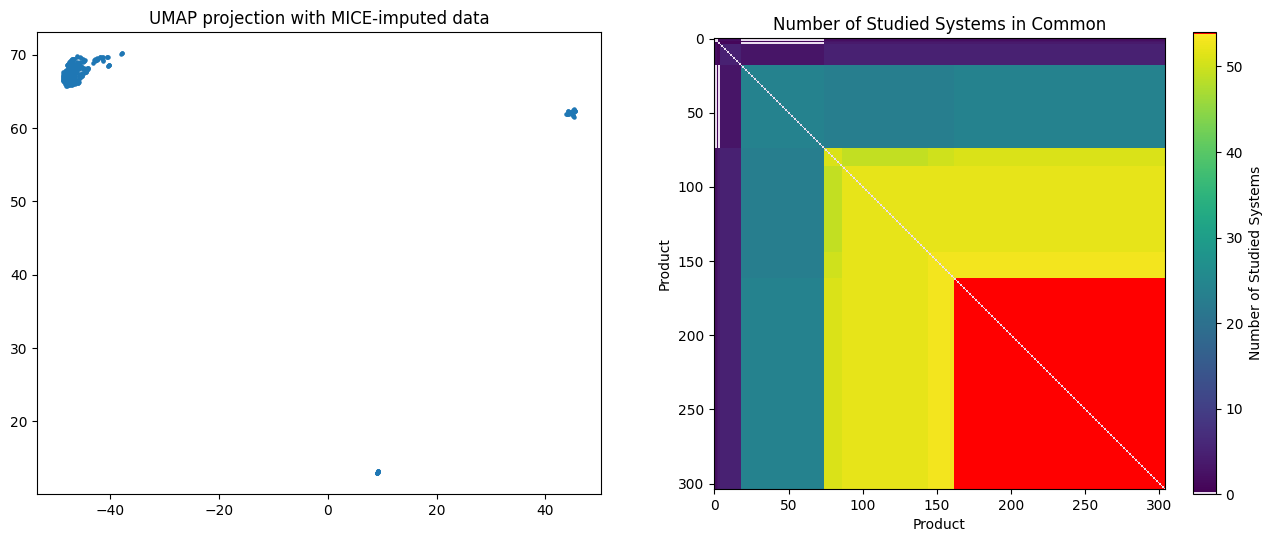

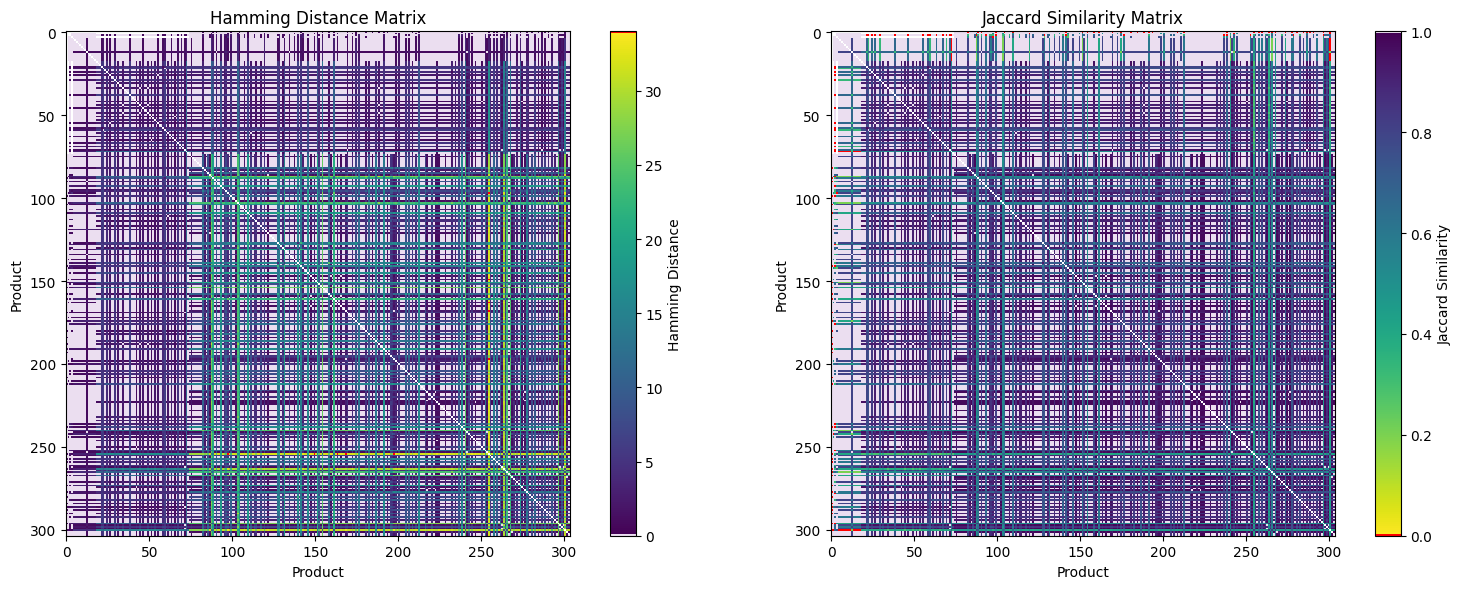

In [22]:
# Code
file_name='vec_fixed_optimized.pkl'
min_number_of_systems=0
data,merged_df,top_min_j,top_min_h,imputed_data,df_vector,r_umap,m_feat=f_main(file_name, min_number_of_systems)

# Distances in log?

In [23]:
np.unique(data)

array([ 0.,  1., nan])

# 4.1. Visualize Existing Tests

In [77]:
def fv_nb_test(data):

    # Data
    no_toxic=np.count_nonzero(data==0,axis=0)
    toxic=np.nansum(data, axis=0)
    total_test=no_toxic+toxic

    # Percentage of toxic results
    toxic_p=toxic/total_test
    

    # Visualisation 
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Colors
    one=np.array([86, 173, 175])/255 # Turq
    two=np.array([57, 91, 142])/255 # Blue - dark
    three=np.array([240, 128, 128])/255 # coral
    four=np.array([255, 87, 51])/255 # Orange
    five=np.array([69, 105, 144])/255 # blue opaco

    # Percentage of Toxicity
    x_values = np.arange(len(toxic))
    axes[0].bar(x_values, toxic_p, color=three)
    axes[0].set_title('Percentage of Toxicity')
    axes[0].set_xlabel('Studied System')
    axes[0].set_ylabel('Toxic Results (%)')
    axes[0].grid(axis = 'y')

    # How many toxic/not toxic
    by_test=np.nansum(data, axis=0)
    # Second histogram
    axes[1].bar(x_values, toxic, color=three)
    axes[1].bar(x_values, no_toxic, bottom=toxic,color=one)
    axes[1].grid(axis = 'y')
    axes[1].set_title('Toxicity Results by Studied System')
    axes[1].set_xlabel('Studied System')
    axes[1].set_ylabel('Frequency')
    
    # Display 
    plt.show()

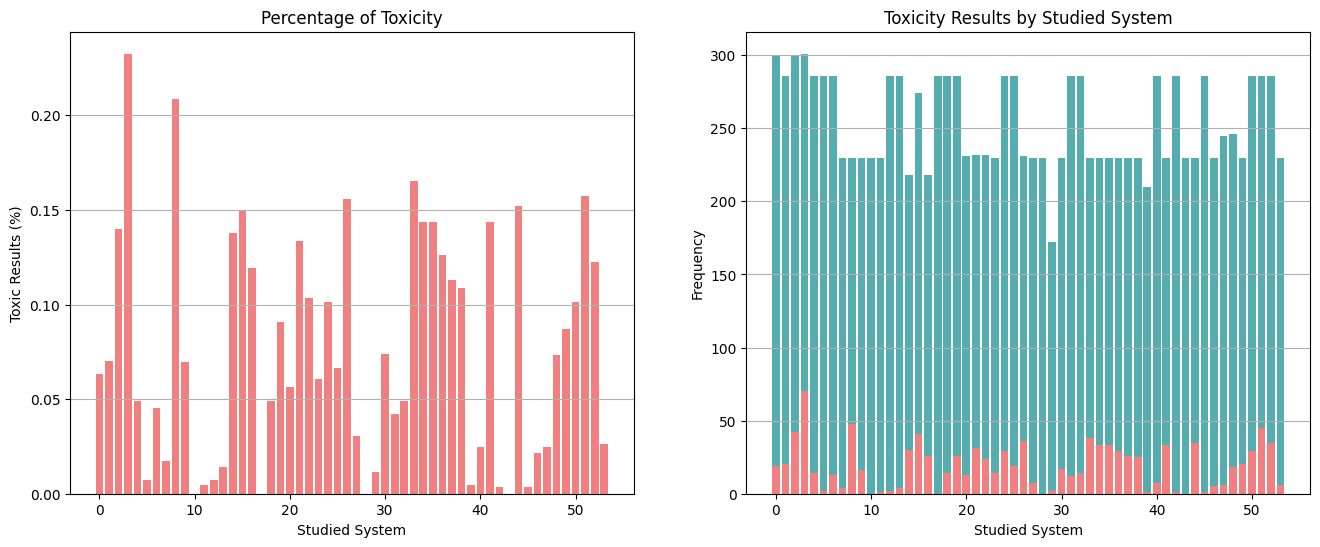

In [78]:
fv_nb_test(data)

# 4.2. Visualize Toxic Tests

In [27]:
def fv_heat(data):
    # In this function we aime to show the toxic test (in blue)
    # In purple if there's not information
    # In green the test is not toxic
    # I added the last column to see if at least one test is toxic, which means that the product is going to be considered toxic (red is toxic)
    
    # Add column "Toxicite"
    new_column = np.nanmax(data, axis=1).reshape(-1, 1)*3
    data = np.hstack((data, new_column))
    
    # data = data.astype(float)
    data = data*1
    data[np.isnan(data)] = 2
    
    one=np.array([218, 247, 166])/255
    two=np.array([235, 222, 240])/255
    three=np.array([235, 245, 251])/255
    four=np.array([231, 76, 60])/255
    cmap = ListedColormap([one, [0,0,1],two,four])
    # cmap='viridis_r'
    
    # Plotting the heatmap with the custom colormap
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap=cmap, cbar=True, vmin=0, vmax=3)
    plt.xlabel('Studied System')
    plt.ylabel('Tested Product')

    # Display the heatmap
    plt.title("Toxicity Heatmap by Test and Product")
    plt.show()
    return data

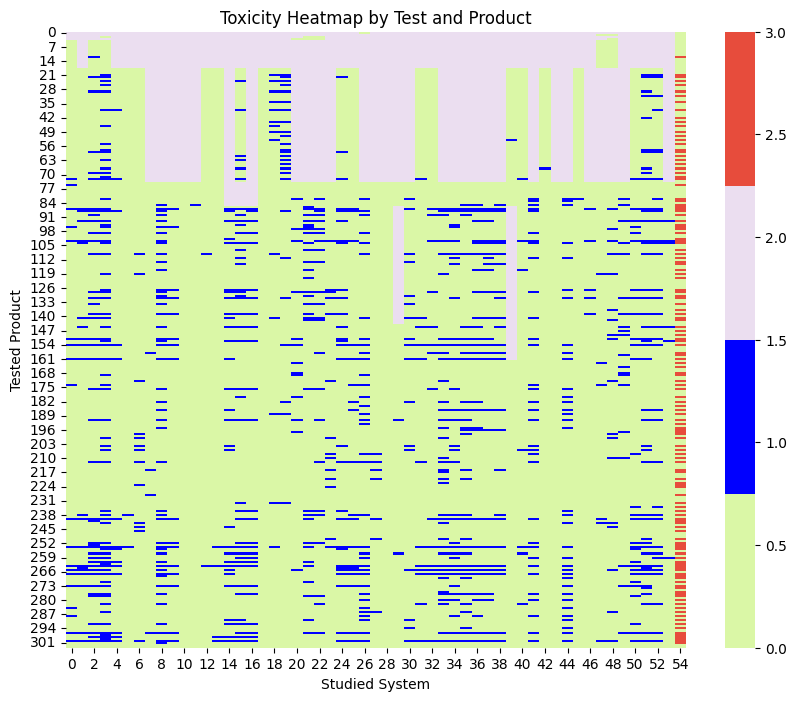

In [28]:
toxic_data=fv_heat(data)

In [29]:
toxic=np.sum(toxic_data[:,-1]>0)
t_total=len(toxic_data)
t_p=toxic/t_total
t_p

0.46710526315789475

# 5. Distribution using  UMAP and Autoencoder

In [30]:
def f_autoencoder(data):
    # Define and train autoencoder
    input_layer = Input(shape=(data.shape[1],))
    encoded = Dense(50, activation='relu')(input_layer)
    encoded = Dense(2, activation='relu')(encoded)  # Reduce to 2D
    decoded = Dense(50, activation='relu')(encoded)
    decoded = Dense(data.shape[1], activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Train autoencoder
    autoencoder.fit(data, data, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
    
    # Use encoder to get reduced data
    reduced_data = encoder.predict(data)
    return reduced_data

In [31]:
# Complete Code
r_autoencoder=f_autoencoder(imputed_data)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6929 - val_loss: 0.6923
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6921 - val_loss: 0.6916
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6912 - val_loss: 0.6908
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.6903 - val_loss: 0.6899
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6893 - val_loss: 0.6890
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.6882 - val_loss: 0.6881
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6870 - val_loss: 0.6870
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.6857 - val_loss: 0.6859
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6842 - val_loss: 0.6846
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6827 - val_loss: 0.6833
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6811 - val_loss: 0.6819
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.6793 - val_loss: 0.6805
Epo

In [83]:
def fv_kmeans(reduced_data,clusters,title,colores,ax):
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3)  # Set the number of clusters you expect
    kmeans.fit(reduced_data)
    labels = kmeans.labels_
    cmap = ListedColormap(colores)
    
    # UMAP scatter plot with color based on K-Means labels
    ax.set_title(title)
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=cmap, s=5)
    
    # # Add color bar to show cluster assignments
    # cbar = plt.colorbar(scatter, ax=ax)
    # cbar.set_label('Cluster Label')

In [92]:
def fv_box(reduced_data,test_data,clusters,title,colores,ax):
    # Apply K-Means clustering
    clusters=3
    kmeans = KMeans(n_clusters=clusters)  # Set the number of clusters you expect
    kmeans.fit(reduced_data)
    labels = kmeans.labels_
    
    # To see the number of toxic for each cluster 
    list_clusters=[0,1,2]
    data_c=[]

    # Count how many toxic we have for each product
    nb_tox=np.nansum(test_data, axis=1)
    
    for i in list_clusters:
        pos=np.where(labels==i)
        temp=nb_tox[pos]
        data_c.append(temp)
    
    # Visualization of toxicity distribution by clusters
    box = ax.boxplot(data_c, patch_artist=True)  
    
    # Use patch_artist to allow coloring
    for patch, color in zip(box['boxes'], colores):
        patch.set_facecolor(color)

    # changing color and linewidth of whiskers
    for whisker in box['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")
    
    # changing color and linewidth of caps
    for cap in box['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)
    
    # changing color and linewidth of
    # medians
    for median in box['medians']:
        median.set(color ='red',
                   linewidth = 3)

    ax.set_title(title)
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Number of Toxic Samples')

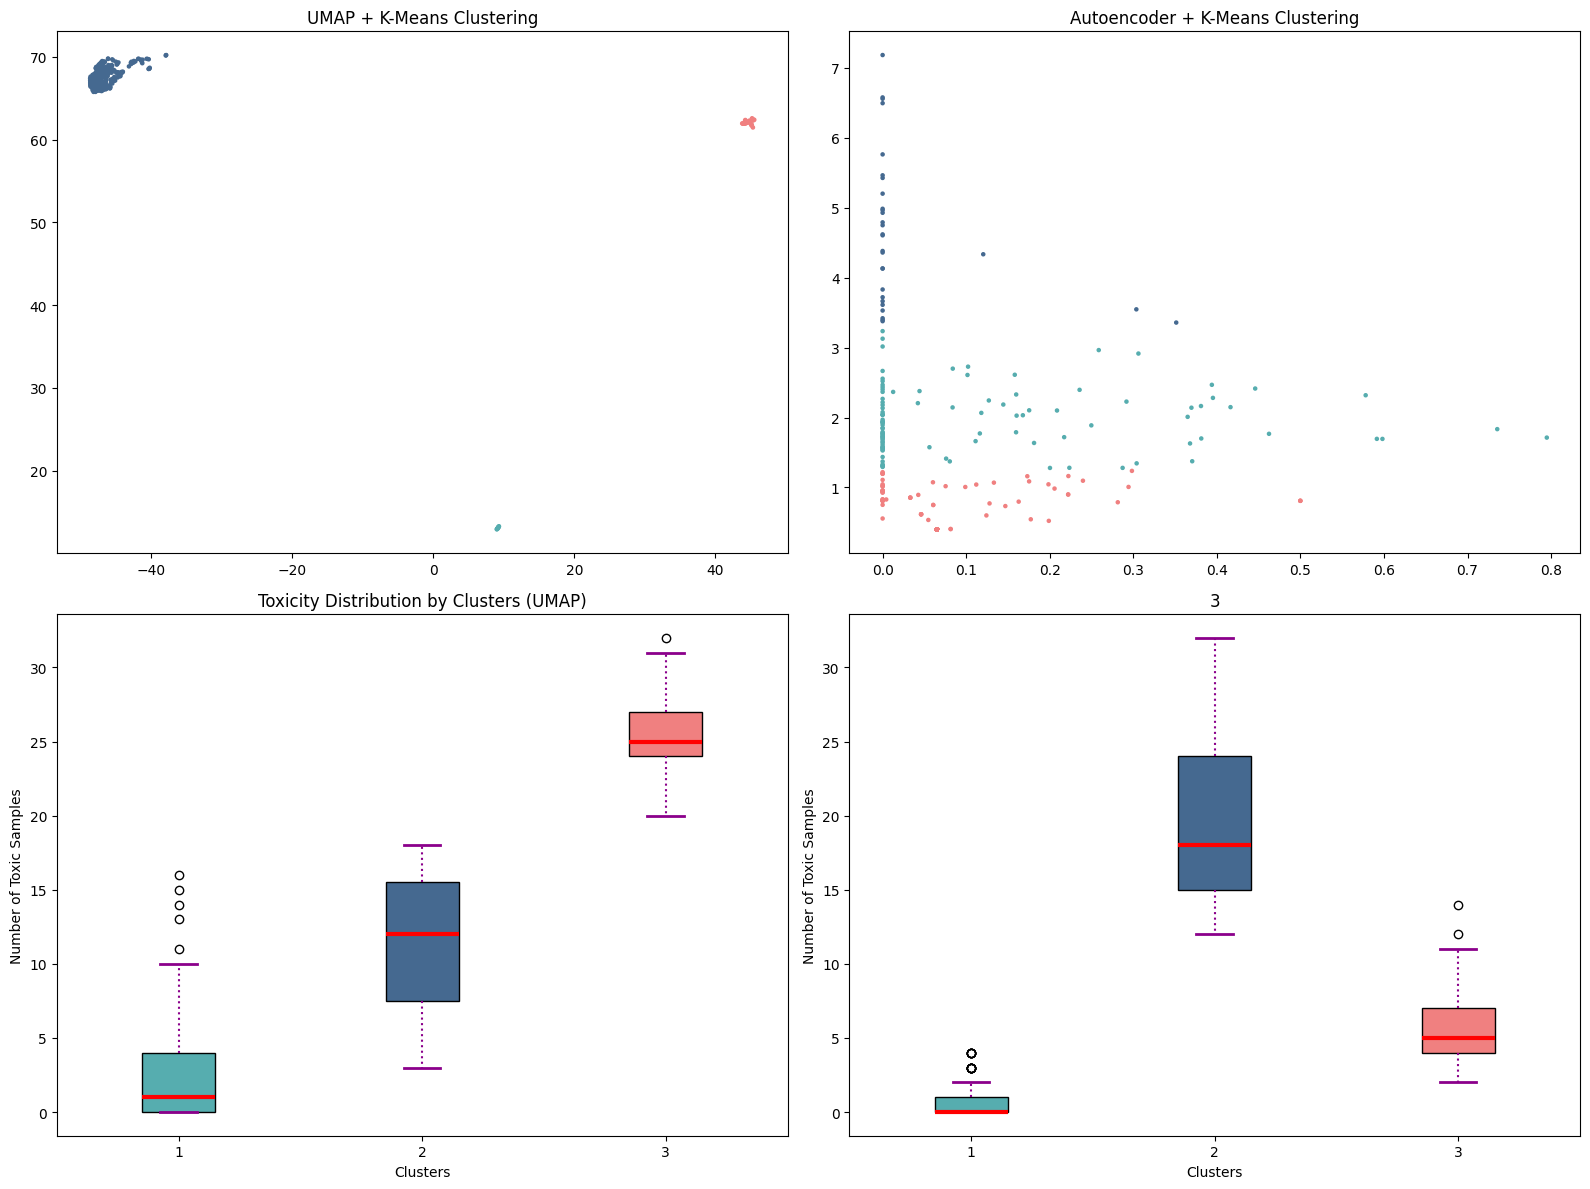

In [93]:
clusters=3

# Set Colors
one=np.array([86, 173, 175])/255 # Turq
two=np.array([57, 91, 142])/255 # Blue - dark
three=np.array([240, 128, 128])/255 # coral
four=np.array([255, 87, 51])/255 # Orange
five=np.array([69, 105, 144])/255 # blue opaco
colors=[one,five,three,four]
colores=colors[:clusters]

# Draw 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Call each function, passing the corresponding subplot axis
fv_kmeans(r_umap, clusters, 'UMAP + K-Means Clustering', colores, axes[0, 0])
fv_kmeans(r_autoencoder, clusters, 'Autoencoder + K-Means Clustering', colores, axes[0, 1])
fv_box(r_umap, imputed_data, clusters, 'Toxicity Distribution by Clusters (UMAP)', colores, axes[1, 0])
fv_box(r_autoencoder, imputed_data, 'Toxicity Distribution by Clusters (Autoencoder)',clusters, colores, axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()

# Display the combined plot
plt.show()

In [35]:
# df_data=pd.DataFrame()

In [36]:

# sns.swarmplot(data=df_data)

### Conclusions

1. Compleating data may not be a good option, at least without making filters to complete only when "enough" data exists